# Classification of Hypnotic Depth

In [3]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU usage
import mne

import torch
import keras
from pathlib import Path
import re
from sklearn.preprocessing import RobustScaler, StandardScaler
from scipy.signal import butter, sosfilt
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit


# helper functions
def preprocess_data(data, baseline_mean):
    # Step 1: Baseline correction (subtract the mean of the first 0.5 seconds for each channel) 
    data_corrected = data - baseline_mean
    
    # Step 2: Robust Scaler (normalize using median and IQR)
    scaler = RobustScaler()
    data_scaled = scaler.fit_transform(data_corrected.T)
    
    # Step 3: Normalization (z-score normalization)
    normalizer = StandardScaler()
    data_normalized = normalizer.fit_transform(data_scaled).T  # Transpose for sklearn, then back
    
    # Step 4: Clamp values greater than 20 standard deviations (becuause of the normalization at the previous step sd is 1)
    std_threshold = 20
    data_clamped = np.clip(data_normalized, -std_threshold, std_threshold)
    
    return data_clamped

def get_averaged_data(data):
    ''' Average over specific brain areas and return a new dataarray '''
    ba_patches = {'LF': ['Fp1', 'F3', 'F7', 'AF3', 'F1', 'F5'],
                  'LC': ['C3', 'T7', 'FC1', 'FC3', 'FC5', 'C1', 'C5', 'FT7'],
                  'LP': ['P3', 'P7', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P5'],
                  'LO': ['O1', 'PO3'],
                  'RF': ['Fp2', 'F4', 'F8', 'AF4', 'F2', 'F6'],
                  'RC': ['C4', 'T8', 'FC2', 'FC4', 'FC6', 'C2', 'C6', 'FT8'],
                  'RP': ['P4', 'P8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P6'],
                  'RO': ['O2', 'PO4'],
                  'FZ': ['Fz', 'Fpz'],
                  'CZ': ['Cz'],
                  'PZ': ['Pz', 'CPz'],
                  'OZ': ['POz', 'Oz', 'Iz']}
    # average over each brain area patch and save in a new empty dataset
    C, S, T, ses = len(ba_patches), data.sizes.get('subject'), data.sizes.get('time'), 4
    data_numpy = np.zeros([S, ses, C, T])
    for i, (v) in enumerate(ba_patches.values()):
        data_numpy[:, :, i, :] = data.sel(channel=v).mean(dim='channel').values
    return data_numpy, list(ba_patches.keys())

def transform_labels(y, n_classes=4):
    """
    Transform the labels into a threshold-based format.
    For a score y, returns a vector indicating if it surpasses each threshold.
    """
    transformed = np.zeros((len(y), n_classes)) 
    for i, val in enumerate(y):
        transformed[i, :val] = 1
    return transformed

/opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/mne/externals/tempita/__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


## DATA

In [2]:
EEG_data_path = Path('/Volumes/Extreme SSD/PhD/OTKA study1/EEG data/BIDS/')

all_data = {}

# is it because of the resampling that there are different number of timepoints?

for root in sorted(EEG_data_path.glob('sub-*')):
    sub_path  = root / 'ses-01/eeg/'
    for data_path in sorted(sub_path.glob('*_eeg.vhdr')):
        bids_id, task = re.match(r'.*/sub-(.*)_ses-01_task-(.*)_eeg.vhdr', str(data_path)).groups()
        if task == 'baseline1':
            print(f'>>>>>>Processing {bids_id} {task}')
            epoch = mne.io.read_raw_brainvision(data_path, verbose=False, eog=['EOG1', 'EOG2'], misc=['ECG'])
            epoch.pick(picks='eeg', exclude=['M1', 'M2'])
            epoch.resample(128)
            epoch = epoch.get_data()
            baseline_mean = epoch.mean(axis=1, keepdims=True)
            continue
    
        if task.__contains__('experience'):
            print(f'>>>>>>Processing {bids_id} {task}')
            epoch = mne.io.read_raw_brainvision(data_path, verbose=False, eog=['EOG1', 'EOG2'], misc=['ECG'])
            epoch.pick(picks='eeg', exclude=['M1', 'M2'])
            epoch.resample(128)
            data = epoch.get_data()
            data_clamped = preprocess_data(data, baseline_mean)
            all_data[f'sub-{bids_id}_{task}'] = data_clamped

NameError: name 'Path' is not defined

In [4]:
## Prepare the data to be converted and stored as a data array

# trim all the data in the dictionary to the minimum length
min_len = min([i.shape[1] for i in list(all_data.values())])
all_data = {k: v[:, :min_len] for k, v in all_data.items()}

# there are two missing tasks for sub-52, we fill them with zeros so th
all_data['sub-52_experience2'] = np.zeros_like(all_data['sub-52_experience1'])
all_data['sub-52_experience3'] = np.zeros_like(all_data['sub-52_experience1'])
data = np.array(list(all_data.values()))
data = data.reshape(52, 4, 56, -1)  # 52 subjects, 4 conditions, 56 channels, time
# rearranging the data for the last participant whose experience 2 and 3 data is missing
data[-1, -1] = data[-1, -3]  
data[-1, -3] = data[-1, -2]

data = xr.DataArray(data, 
                    dims=('subject', 'tasks', 'channel', 'time'),
                    coords={'subject': np.unique([i.split('_')[0] for i in all_data.keys()]),
                            'tasks': ['experience1', 'experience2', 'experience3', 'experience4'],
                            'channel': epoch.ch_names,
                            'time': np.arange(min_len)}
                            )

# data.to_netcdf('/Users/yeganeh/Codes/otka_data/EEG/experiment_EEG_data.nc5', engine='h5netcdf')

ValueError: min() arg is an empty sequence

## Xy

In [5]:
# set seeds for reproducibility
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
set_seed(42)

In [6]:
# open EEG and session data
EEG_data = xr.open_dataarray('/Users/yeganeh/Codes/otka_data/EEG/experiment_EEG_data.nc5')
session_data = pd.read_csv('/Users/yeganeh/Codes/otka_data/behavioral/behavioral_data.csv')
# self_report = pd.read_csv('data/OTKA/embedded_text_emb_3.csv')
# session_data['cluster_labels'] = self_report['cluster_KMeans']

time_dim = 512
filtering = True
only_labelled_hypnosis = True
channels = ['Oz', 'Fz', 'Cz', 'Pz', 'Fp1', 'Fp2', 'F1', 'F2']
average_over_channels = True
output_head = 'cluster_labels'  # 'score' or 'binary_scores' or 'gpt_classification'
n_classes = 2

if average_over_channels:
    X_input, channels = get_averaged_data(EEG_data)
else:
    X_input = EEG_data.sel(channel=channels).to_numpy()

# including only hypnosis sessions
if only_labelled_hypnosis:
    print('>>>>> Including only labelled hypnosis sessions')
    session_data = session_data.query('description == "hypnosis"')[['bids_id', 'score', 'session', 'gpt_classification',
                                                                    'cluster_small']].set_index('bids_id')
    X_input_hyp =  np.zeros([52, 2, len(channels), X_input.shape[-1]])
    for i in range(X_input.shape[0]):
        ses = session_data.loc[i+1, 'session'].values - 1
        X_input_hyp[i] = X_input[i, ses, :, :]
    X_input = X_input_hyp
    del X_input_hyp

# preparing x
if filtering:
    sos = butter(4, 1, btype='high', fs=128, output='sos')
    X_input = sosfilt(sos, X_input, axis=-1)

X_input = torch.tensor(X_input.squeeze()).unfold(-1, time_dim, time_dim).permute(0, 1, 3, 4, 2).flatten(0, 1)

# remove missing sessions for sub-52 depending on which sessions are included
remove_sess = -2 if only_labelled_hypnosis else [-2, -3]
X_input = np.delete(X_input, remove_sess, axis=0)
remove_ind = 102 if only_labelled_hypnosis else [205, 206]
session_data = session_data.reset_index().drop(index=remove_ind)  # TODO: does this also work for the condition when only labelled hypnosis == False?

# prepare y
if output_head == 'gpt_classification':
    y = session_data['gpt_classification'].apply(lambda x: 0 if x == 'no hypnosis' else 1 if x == 'shallow hypnosis' else 2)

elif output_head == 'ordinal_scores':
    y = session_data['score'].apply(lambda x: 0 if x <= 1 else 1 if x<7 else 2)

elif output_head == 'binary_scores':
    med = session_data['score'].median()
    y = session_data['score'].apply(lambda x: 0 if x>=med else 1)  # TODO: when we include only hypnosis sessions, we need to remove the equal sign to get more balanced classes

elif output_head == 'cluster_labels':
    y = session_data['cluster_small']

groups = session_data['bids_id'].values
y = y.values

>>>>> Including only labelled hypnosis sessions


In [7]:
# prepare Kfold cross validation
cross_val = True

if cross_val:
    n_splits = 3
    group_kfold = StratifiedGroupKFold(n_splits=n_splits)
    train_val_splits = []
    for train_idx, val_idx in group_kfold.split(X_input, y, groups=groups):
        train_val_splits.append((train_idx, val_idx))

    # make sure that the splits are stratified and ther is a balance between the classes
    for train_idx, val_idx in train_val_splits:
        print(np.unique(y[train_idx], return_counts=True)[1] / len(y[train_idx]), np.unique(y[val_idx], return_counts=True)[1] / len(y[val_idx]))

else:
    group_shuffle = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=8)  # random state == 9
    train_idx, val_idx = next(group_shuffle.split(X_input, y, groups=groups))
    print(np.unique(y[train_idx], return_counts=True)[1] / len(y[train_idx]), np.unique(y[val_idx], return_counts=True)[1] / len(y[val_idx]))

[0.52173913 0.47826087] [0.52941176 0.47058824]
[0.52173913 0.47826087] [0.52941176 0.47058824]
[0.52941176 0.47058824] [0.51428571 0.48571429]


In [8]:
import torch.nn.functional as F

if output_head == 'gpt_classification':
    y = F.one_hot(torch.tensor(y), num_classes=3).float()
    y = y.reshape(-1, 1, 3).repeat(1, X_input.shape[1], 1)

elif output_head == 'ordinal_scores':
    y = transform_labels(y, n_classes=n_classes)
    y = torch.tensor(y).unsqueeze(1).repeat(1, X_input.shape[1], 1)

else:
    y = torch.tensor(y).reshape(-1, 1).repeat(1, X_input.shape[1])

## MODEL

In [40]:
from src.EEGModalNet.models.common import Classifier

In [ ]:
n_epochs = 20
if cross_val:
    all_val_acc = []
    all_acc = []
    all_loss = []
    all_val_loss = []

    for i in range(n_splits):
        print(f'>>>>>> Fold {i+1}')
        model = Classifier(time_dim=512, feature_dim=len(channels), use_sublayer=False, dropout_rate=0.5)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        model.train()
        set_seed(42)
        print("Training mode:", model.training)
        train_idx, val_idx = train_val_splits[i]
        history = model.fit(X_input[train_idx].flatten(0, 1), y[train_idx].flatten(0, 1),
                            epochs=n_epochs,
                            batch_size=64,
                            validation_data=(X_input[val_idx].flatten(0, 1), y[val_idx].flatten(0, 1)))

        all_val_acc.append(history.history['val_accuracy'])
        all_acc.append(history.history['accuracy'])
        all_loss.append(history.history['loss'])
        all_val_loss.append(history.history['val_loss'])

        # # save the model
        # model.save(f'data/trainings/training_19092024/cv/model_{i+1}.model.keras')
else:
    model = Classifier(time_dim=512, feature_dim=len(channels), use_sublayer=False)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    # model.train()
    print("Training mode:", model.training)
    history = model.fit(X_input[train_idx].flatten(0, 1), y[train_idx].flatten(0, 1),
                        epochs=n_epochs,
                        batch_size=64,
                        validation_data=(X_input[val_idx].flatten(0, 1), y[val_idx].flatten(0, 1)))

Text(0.5, 1.0, 'Loss')

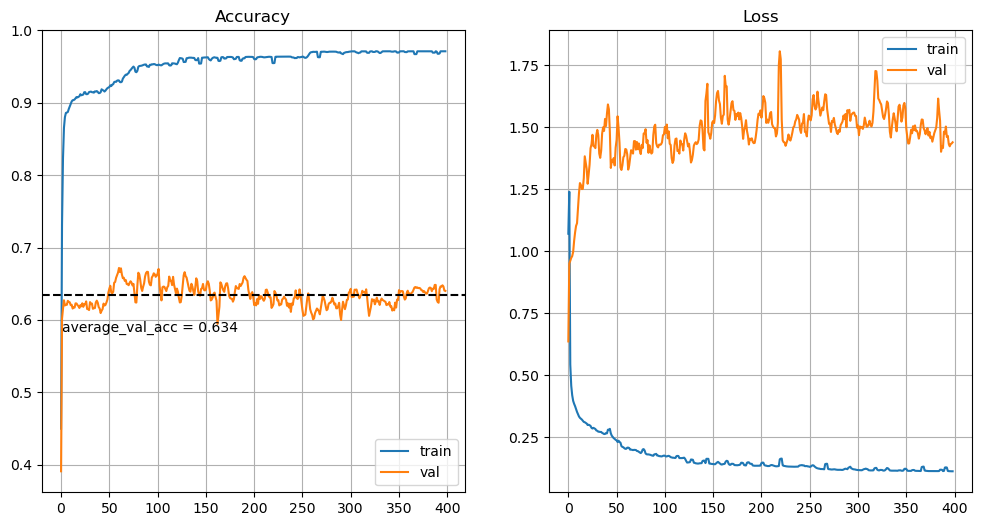

In [51]:
# visualize the accuaracy and loss
def smooth(y, box_pts=3):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

acc = history['accuracy'].values.reshape(3, -1)[:2].mean(axis=0)
acc_val = history['val_accuracy'].values.reshape(3, -1)[:2].mean(axis=0)
loss = history['loss'].values.reshape(3, -1)[:2].mean(axis=0)
loss_val = history['val_loss'].values.reshape(3, -1)[:2].mean(axis=0)
acc_val_mean = round(acc_val.mean(), 3)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(smooth(acc)[:-1], label='train')
plt.plot(smooth(acc_val)[:-1], label='val')
plt.legend()
plt.grid()
plt.axhline(acc_val_mean, color='black', linestyle='--')
plt.text(1, acc_val_mean-0.05, f'average_val_acc = {acc_val_mean}', color='black')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(smooth(loss)[:-1], label='train')
plt.plot(smooth(loss_val)[:-1], label='val')
plt.legend()
plt.grid()
plt.title('Loss')

Text(0.5, 1.0, 'Loss')

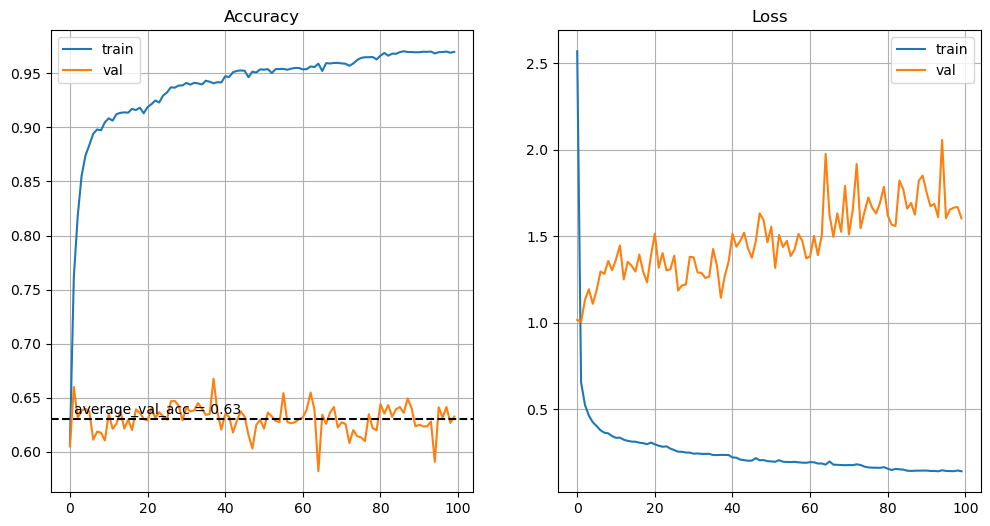

In [11]:
# visualize the accuaracy and loss

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.mean(all_acc, axis=0), label='train')
plt.plot(np.mean(all_val_acc, axis=0), label='val')
plt.legend()
plt.grid()
plt.axhline(0.63, color='black', linestyle='--')
plt.text(1, 0.635, 'average_val_acc = 0.63', color='black')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(np.mean(all_loss, axis=0), label='train')
plt.plot(np.mean(all_val_loss, axis=0), label='val')
plt.legend()
plt.grid()
plt.title('Loss')

Text(0.5, 1.0, 'Validation accuracy distribution')

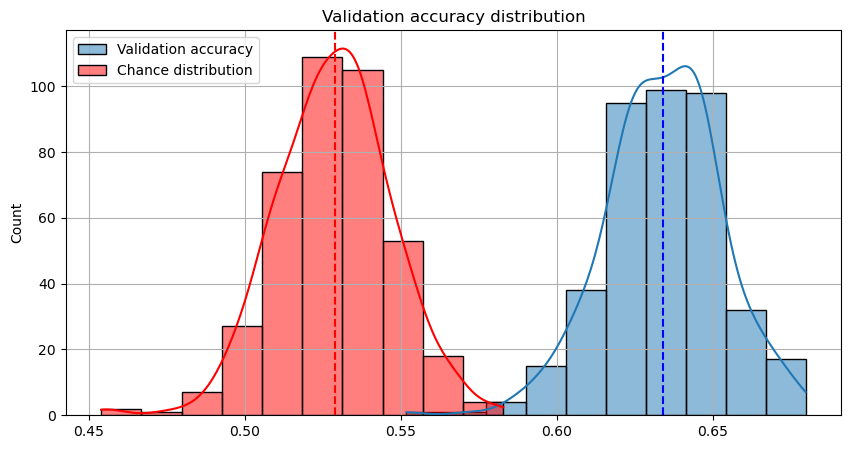

In [95]:
chance = np.random.normal(0.52941176, acc_val.std(), len(acc_val))
# histograph of the validation accuracy
plt.figure(figsize=(10, 5))
sns.histplot(acc_val, bins=10, kde=True, label='Validation accuracy')
sns.histplot(chance, bins=10, kde=True, color='red', label='Chance distribution')
plt.axvline(0.634, color='blue', linestyle='--')
plt.axvline(0.529, color='red', linestyle='--')
plt.legend()
plt.grid()
plt.title('Validation accuracy distribution')

In [9]:
train_val_splits

[(array([  4,   5,   6,   7,   8,   9,  10,  11,  16,  17,  18,  19,  22,
          23,  24,  25,  26,  27,  28,  29,  32,  33,  36,  37,  38,  39,
          42,  43,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  60,
          61,  62,  63,  64,  65,  68,  69,  70,  71,  74,  75,  76,  77,
          82,  83,  84,  85,  86,  87,  90,  91,  92,  93,  94,  95,  98,
          99, 100, 101, 102]),
  array([ 0,  1,  2,  3, 12, 13, 14, 15, 20, 21, 30, 31, 34, 35, 40, 41, 44,
         45, 56, 57, 58, 59, 66, 67, 72, 73, 78, 79, 80, 81, 88, 89, 96, 97])),
 (array([  0,   1,   2,   3,   6,   7,  10,  11,  12,  13,  14,  15,  18,
          19,  20,  21,  24,  25,  28,  29,  30,  31,  34,  35,  36,  37,
          40,  41,  42,  43,  44,  45,  50,  51,  52,  53,  56,  57,  58,
          59,  60,  61,  62,  63,  66,  67,  68,  69,  72,  73,  74,  75,
          78,  79,  80,  81,  86,  87,  88,  89,  92,  93,  94,  95,  96,
          97, 100, 101, 102]),
  array([ 4,  5,  8,  9, 16, 17, 22, 23, 

In [18]:
from src.EEGModalNet.models.common import Classifier
model = Classifier(feature_dim=len(channels), dropout_rate=0)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.load_weights('logs/label_classifier17092024_1.model.keras')
model.train()

train_idx, val_idx = train_val_splits[0]
y_test = y[train_idx].flatten(0, 1)
X_test = X_input[train_idx].flatten(0, 1)

y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
y_pred = y_pred > 0.5
accuracy_score(y_test, y_pred)

/opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


0.49568004459308806

### evaluate

In [7]:
def predict_rating(model, X):
    preds = model.predict(X)
    return np.sum(preds > 0.5, axis=-1)  # Count how many thresholds were surpassed (predicted probability > 0.5)

y_pred = predict_rating(model, X_input[val_idx].flatten(0, 1))
y_true = ops.sum(ops.cast(y[val_idx].flatten(0, 1), dtype='float32'), axis=-1).cpu()

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [118]:
np.unique(torch.sum(y[train_idx], axis=-1)[:, 0], return_counts=True)[1]/206

array([0.25242718, 0.30097087, 0.23300971])

In [135]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

0.2504370629370629
              precision    recall  f1-score   support

         0.0       0.20      0.17      0.19      1352
         1.0       0.28      0.28      0.28      1872
         2.0       0.25      0.30      0.27      1352

    accuracy                           0.25      4576
   macro avg       0.24      0.25      0.24      4576
weighted avg       0.25      0.25      0.25      4576



### Distribution

In [37]:
# save model & model config
model_path = 'data/trainings/training_19092024/'
model_name = 'HD_classify_'+ '8_channels'
model.save(model_path+f'{model_name}.model.keras')
model_config = model.model.get_config()
import json
with open(f'{model_name}_config.json', 'w') as f:
    json.dump(model_config, f)

In [123]:
# results
df = pd.read_csv('logs/history.csv', index_col=0)
df2 = pd.read_csv('logs/history_last3folds.csv', index_col=0).iloc[300:600]

df = df.drop(df.index[-1000:])

df_new = pd.DataFrame()

for i in range(3):
    df_new = pd.concat([df_new, df.iloc[i*500:i*500+300]], axis=0)

df_new = pd.concat([df_new, df2], axis=0).reset_index(drop=True)

Text(0.5, 1.0, 'Cross-Validated Accuracy Distribution')

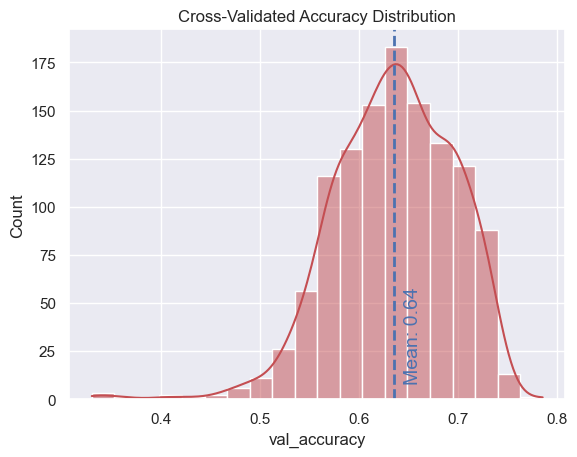

In [141]:
import seaborn as sns
sns.set_theme(style='darkgrid')
sns.histplot(df_new['val_accuracy'], bins=20, kde=True, color='r', label='Validation Accuracy')
# plot a vertical line at the mean.
plt.axvline(df_new['val_accuracy'].mean(), color='b', linestyle='dashed', linewidth=2)
# add the mean value to the plot.
plt.text(df_new['val_accuracy'].mean() + 0.01, 10, f'Mean: {df_new["val_accuracy"].mean():.2f}', rotation=90, color='b', fontsize=14)
plt.title('Cross-Validated Accuracy Distribution')

## Interpretablity Techniques

In [20]:
ba_patches = {'LF': ['Fp1', 'F3', 'F7', 'AF3', 'F1', 'F5'],
                  'LC': ['C3', 'T7', 'FC1', 'FC3', 'FC5', 'C1', 'C5', 'FT7'],
                  'LP': ['P3', 'P7', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P5'],
                  'LO': ['O1', 'PO3'],
                  'RF': ['Fp2', 'F4', 'F8', 'AF4', 'F2', 'F6'],
                  'RC': ['C4', 'T8', 'FC2', 'FC4', 'FC6', 'C2', 'C6', 'FT8'],
                  'RP': ['P4', 'P8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P6'],
                  'RO': ['O2', 'PO4'],
                  'FZ': ['Fz', 'Fpz'],
                  'CZ': ['Cz'],
                  'PZ': ['Pz', 'CPz'],
                  'OZ': ['POz', 'Oz', 'Iz']}
channels = ba_patches.keys()

/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_9809/1348089256.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[list(channels)[i] for i in srt_idx], y=sorted(attributions), palette="viridis")


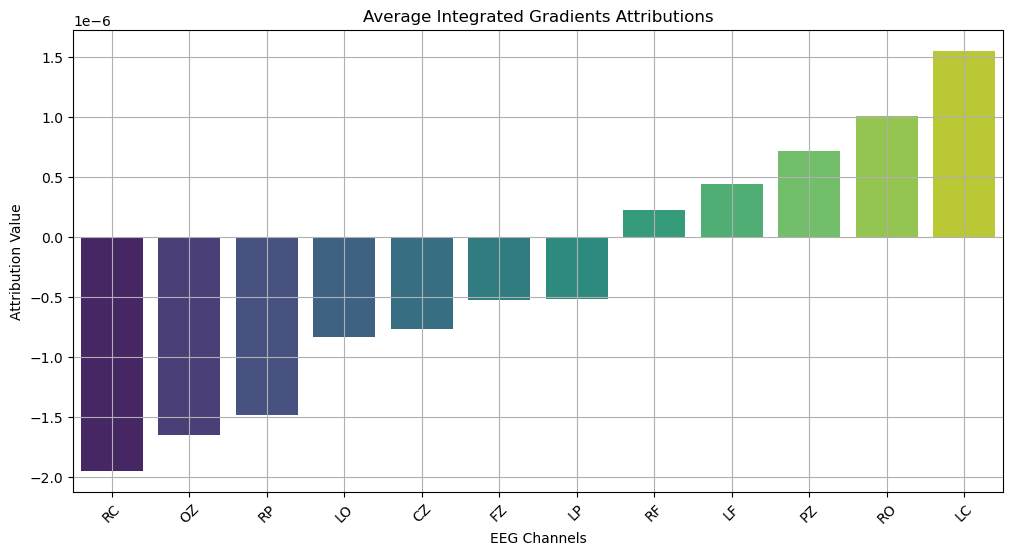

In [34]:
# Select a sample from your test data
all_attributions = np.load('data/OTKA/interpretability/all_attributions.npy')
import seaborn as sns
from matplotlib import pyplot as plt
attributions = all_attributions.mean(axis=0).mean(axis=0).mean(axis=0).mean(axis=0)
# attributions2 = all_attributions[1].mean(axis=0).mean(axis=0).mean(axis=0)

# # Example of visualizing the attributions as a heatmap
# plt.figure(figsize=(5, 5))
# sns.heatmap(attributions.squeeze().mean(0)[:, np.newaxis], cmap='coolwarm', cbar=True)
# plt.title('Integrated Gradients Attributions for Hypnotized Class')
# plt.xlabel('EEG Channels')

# # include the channels labels in the x-axis
# plt.yticks(ticks=np.arange(len(channels)), labels=channels, rotation=45)
# plt.ylabel('Timepoints')
# plt.show()
plt.figure(figsize=(12, 6))
srt_idx = np.argsort(attributions)
sns.barplot(x=[list(channels)[i] for i in srt_idx], y=sorted(attributions), palette="viridis")
plt.title('Average Integrated Gradients Attributions')
plt.xlabel('EEG Channels')
plt.ylabel('Attribution Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [24]:
attributions

array([ 4.4444192e-07,  1.5493279e-06, -5.1589058e-07, -8.3309936e-07,
        2.3056201e-07, -1.9499059e-06, -1.4806358e-06,  1.0090523e-06,
       -5.2511024e-07, -7.6492972e-07,  7.1513193e-07, -1.6519657e-06],
      dtype=float32)

In [22]:
# find the indices of the top 5 channels
sorted(attributions)

[-1.949906e-06,
 -1.6519657e-06,
 -1.4806358e-06,
 -8.3309936e-07,
 -7.649297e-07,
 -5.2511024e-07,
 -5.158906e-07,
 2.3056201e-07,
 4.4444192e-07,
 7.1513193e-07,
 1.0090523e-06,
 1.5493279e-06]

In [ ]:
test_set = X_input[val_idx].flatten(0, 1)
all_attributions = []

for sample in test_set[:10]:  # Loop over all EEG samples
    attributions = integrated_gradients(model, sample, target_class=0)  # Get attributions for each sample
    all_attributions.append(attributions)

all_attributions = np.array(all_attributions)
avg_attributions = np.mean(all_attributions, axis=0)

## Gender Classification Using OTKA data

In [41]:
# gender data (y)
one_hot_encoding = False

gender = pd.read_excel('/Users/yeganeh/Codes/SugNet/data/PLB_HYP_data_MASTER.xlsx')[['bids_id', 'gender']].dropna().set_index('bids_id')
gender['gender'] = gender['gender'].apply(lambda x: 1 if x == 'Female' else 0)
y_ = gender['gender'].values.repeat(4)[:-2]  # repeat for the 4 sessions and remove the last two entries because the last two sessions are missing for the last participant

# subject ids for grouped cross validation
groups = gender.index.to_numpy() - 1
groups = groups.repeat(4)[:-2]

In [74]:
# X
EEG_data = xr.open_dataarray('data/OTKA/experiment_EEG_data.nc5')

n_subject = 52
time_dim = 512
filtering = True
average_channels = True
channels = ['Oz', 'Fz', 'Cz', 'Pz', 'Fp1', 'Fp2', 'F1', 'F2']

if average_channels:
    X_input, channels = get_averaged_data(EEG_data)
else:
    X_input = EEG_data.sel(subject=EEG_data.subject[:n_subject], channel=channels).to_numpy()

# remove placeholder data (zeros) from the missing sessions of the last participant 
X_input = torch.tensor(X_input).flatten(0, 1)
X_sub52_ses4 = X_input[-1].unsqueeze(0)
X_input = X_input[:-3]
X_input = torch.cat([X_input, X_sub52_ses4], dim=0)

# preparing x
if filtering:
    sos = butter(4, 1, btype='high', fs=128, output='sos')
    X_input = sosfilt(sos, np.array(X_input), axis=-1)

X_input = torch.tensor(X_input).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1)

In [86]:
# # one hot encoding of the gender data
if one_hot_encoding:
    y = np.eye(2)[y_].astype(int)
    y = torch.tensor(y).reshape(-1, 1, 2).repeat(1, X_input.shape[1], 1)
else:
    y = torch.tensor(y_).reshape(-1, 1).repeat(1, X_input.shape[1])

In [87]:
# Train/test split
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
cross_val = False

if cross_val:
    n_splits = 3
    group_kfold = StratifiedGroupKFold(n_splits=n_splits)
    train_val_splits = []
    for train_idx, val_idx in group_kfold.split(np.array(X_input), y_, groups=groups):
        train_val_splits.append((train_idx, val_idx))
else:
    group_shuffle = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=2)  
    train_idx, val_idx = next(group_shuffle.split(np.array(X_input), y_, groups=groups))

np.unique(y[train_idx].flatten(0, 1), return_counts=True)[1] / len(y[train_idx].flatten(0, 1)), np.unique(y[val_idx].flatten(0, 1), return_counts=True)[1] / len(y[val_idx].flatten(0, 1))

(array([0.2345679, 0.7654321]), array([0.27272727, 0.72727273]))

### model

In [3]:
# model
from src.EEGModalNet.models.common import ResidualBlock
import keras
from keras import layers
from keras import regularizers
l2_lambda = 0.01
dropout_rate = 0.5

class Critic(keras.Model):
    def __init__(self, time_dim, feature_dim, use_sublayer):
        super(Critic, self).__init__()

        self.input_shape = (time_dim, feature_dim)
        self.use_sublayer = use_sublayer

        self.model = keras.Sequential([
            keras.Input(shape=self.input_shape),
            ResidualBlock(feature_dim * 4, 5, activation='relu'),
            layers.Conv1D(2, 5, padding='same', activation='relu', name='conv3', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Conv1D(1, 5, padding='same', activation='relu', name='conv4', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Flatten(name='dis_flatten'),
            layers.Dense(512, name='dis_dense1', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(128, name='dis_dense2', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(32, name='dis_dense3', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(8, name='dis_dense4', activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)),
            layers.Dropout(dropout_rate),
            layers.Dense(1, name='sigmoid', activation='sigmoid', kernel_regularizer=regularizers.L2(l2_lambda))
        ], name='critic')
    
    def call(self, inputs):
        return self.model(inputs)

def build_model():
    model = Critic(time_dim=512, feature_dim=len(channels), use_sublayer=False)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
if cross_val:
    k = 3
    n_epochs = 3
    all_val_acc = []
    all_acc = []
    all_loss = []
    all_val_loss = []

    for i in range(k):
        print(f'>>>>>> Fold {i+1}')
        model = build_model()
        train_idx, val_idx = train_val_splits[i]
        history = model.fit(X_input[train_idx].flatten(0, 1), y[train_idx].flatten(0, 1),
                            epochs=n_epochs,
                            batch_size=64,
                            validation_data=(X_input[val_idx].flatten(0, 1), y[val_idx].flatten(0, 1)))

        all_val_acc.append(history.history['val_accuracy'])
        all_acc.append(history.history['accuracy'])
        all_loss.append(history.history['loss'])
        all_val_loss.append(history.history['val_loss'])

else:
    model = build_model()
    history = model.fit(X_input[train_idx].flatten(0, 1), y[train_idx].flatten(0, 1),
                        epochs=40,
                        batch_size=64,
                        validation_data=(X_input[val_idx].flatten(0, 1), y[val_idx].flatten(0, 1)))

## Incorporating the free-response questions to the model

This section takes advanteges of the free-response self reports, participants provided about their hypnotic experience:
In this part, we first vectorize and then cluster the self-reports. later these cluster will be added as a seprated head to the model above so that we will train a multi-task model.

### text-clustering (topic-modeling)

In [1]:
import pandas as pd
session_data = pd.read_csv('/Users/yeganeh/Codes/otka_data/behavioral/behavioral_data.csv')
# session_data = session_data.query('description == "hypnosis"')[['bids_id', 'score', 'english_text']].set_index('bids_id')
self_reports = session_data.loc[:, 'english_text']

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Vectorizing text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(self_reports)

# Clustering using k-means
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# # Print out cluster labels for each self-report
clusters = kmeans.labels_
# for i, report in enumerate(self_reports):
#     print(f"Report: {report} --> Cluster: {clusters[i]}")

np.unique(clusters, return_counts=True)[1] / len(clusters)

array([0.27884615, 0.47115385, 0.25      ])

### Sentiment Analysis

In [ ]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis', device='mps')
classifier(self_reports[0])

### Zero-shot classification

In [7]:
import openai
import time
openai.api_key = "my_key"

In [ ]:
classifications = []

for i, report in enumerate(self_reports):
    prompt = f"Classify the following: '{report}'"

    try:
        # Use the chat completion endpoint
        response = openai.chat.completions.create(
            model="gpt-4o", 
            messages=[
                {"role": "system", "content": "You are a translator and a classifier that categorizes the depth of hypnosis based on self-reports written in Hungarian. Classify the following text into three categories: 'shallow hypnosis' or 'deep hypnosis'. be concise and clear."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=40,
            temperature=0  # Deterministic output
        )
        
        # Extract classification from response
        classification = response.choices[0].message.content.strip()
        classifications.append(classification)

        print(f"Processed report {i+1}/{len(self_reports)}: {classification}")

    except Exception as e:
        print(f"Error processing report {i+1}: {e}")
        classifications.append("Error")

    # time.sleep(1)  # avoid rate limiting

<Axes: xlabel='score', ylabel='Count'>

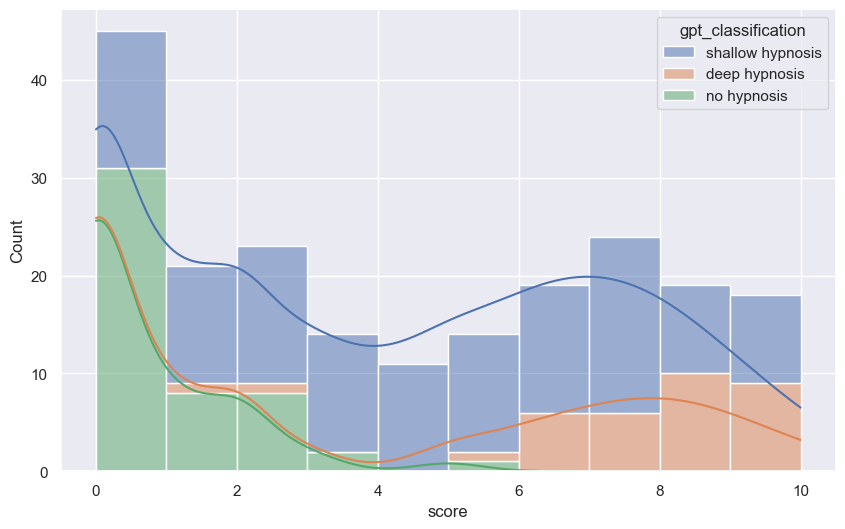

In [110]:
# plot participnats ratings against gpt_classification
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid')
plt.figure(figsize=(10, 6))
sns.histplot(data=session_data, x='score', hue='gpt_classification', multiple='stack', bins=10, kde=True)

### Text embedding

In [ ]:
self_reports = session_data[['bids_id', 'english_text']].set_index('bids_id')

In [13]:
from openai import OpenAI
client = OpenAI(api_key="my_key")

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

self_reports['ada_embedding'] = self_reports.english_text.apply(lambda x: get_embedding(x, model='text-embedding-3-small'))

In [ ]:
# Step 2: Cluster the embeddings using KMeans
embeddings = np.array(self_reports.ada_embedding.tolist())
def cluster_embeddings(embeddings, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
    return kmeans.labels_

# Cluster the embeddings
cluster_labels = cluster_embeddings(embeddings, n_clusters=2)

self_reports['cluster'] = cluster_labels
self_reports['score'] = session_data['score']
# self_reports.to_csv('data/OTKA/embedded_text_emb_3_small.csv', index=False)

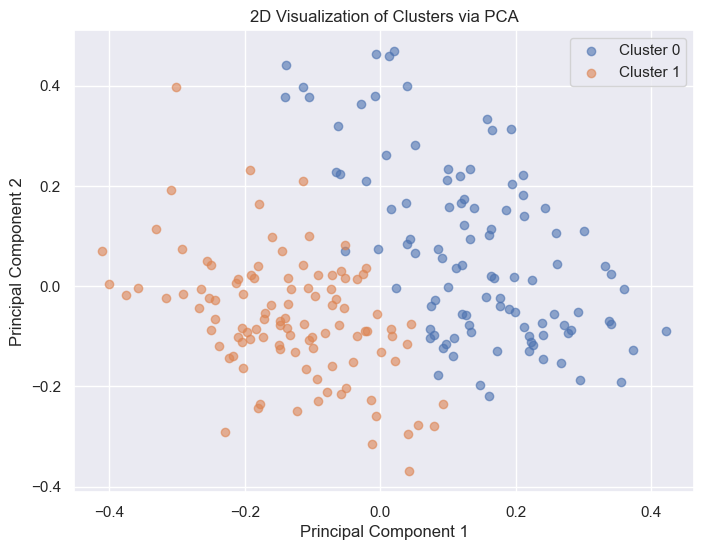

In [42]:
from sklearn.decomposition import PCA

# Step 1: Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings) 

def visualize_clusters(reduced_embeddings, cluster_labels):
    plt.figure(figsize=(8, 6))
    
    # Plot the points for each cluster
    for label in np.unique(cluster_labels):
        cluster_points = reduced_embeddings[cluster_labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}", alpha=0.6)
    
    plt.title("2D Visualization of Clusters via PCA")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()

# Step 2: Visualize the clusters with t-SNE
visualize_clusters(reduced_embeddings, cluster_labels)


### Investigate the characteristics of each cluster

In [83]:
session_data = pd.read_csv('/Users/yeganeh/Codes/otka_data/behavioral/behavioral_data.csv')
self_reports = pd.read_csv('data/OTKA/embedded_text_emb_3_large.csv')
session_data['cluster_label'] = self_reports['cluster_KMeans']
texts_cluster_0 = self_reports.query('cluster_KMeans == 0')['english_text']
texts_cluster_1 = self_reports.query('cluster_KMeans == 1')['english_text']

<Axes: xlabel='score', ylabel='Count'>

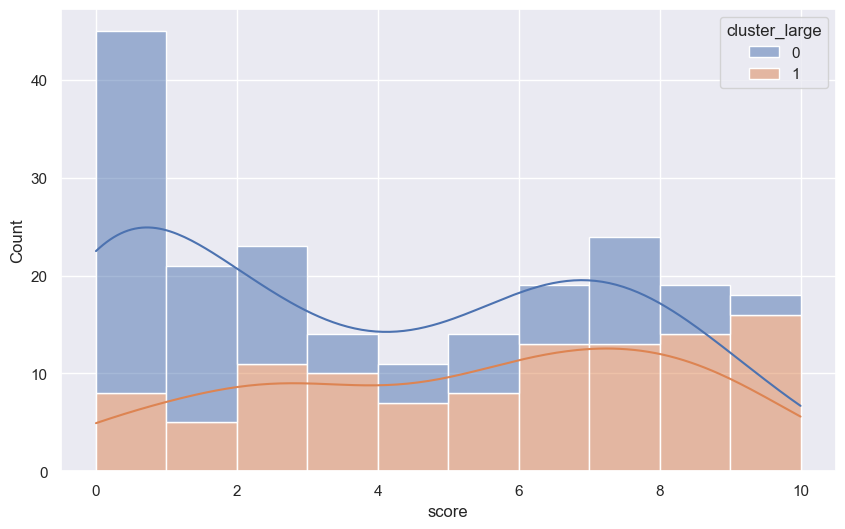

In [70]:
# visualize the clusters_labels
sns.set_theme(style='darkgrid')
plt.figure(figsize=(10, 6))
sns.histplot(data=self_report, x='score', hue='cluster_large', multiple='stack', bins=10, kde=True)

<Axes: xlabel='description', ylabel='Count'>

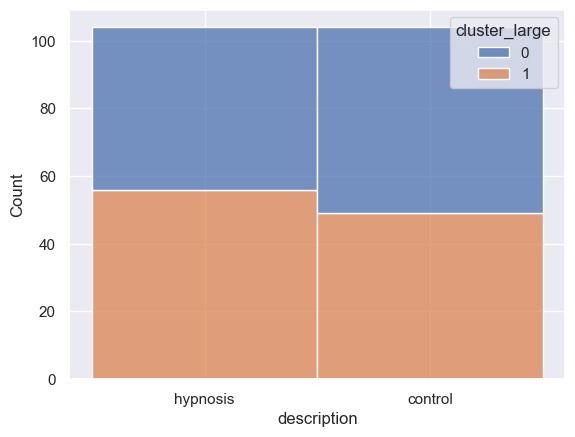

In [84]:
sns.histplot(data=session_data, x='description', hue=self_report['cluster_large'], multiple='stack', bins=10)

<Axes: xlabel='procedure', ylabel='Count'>

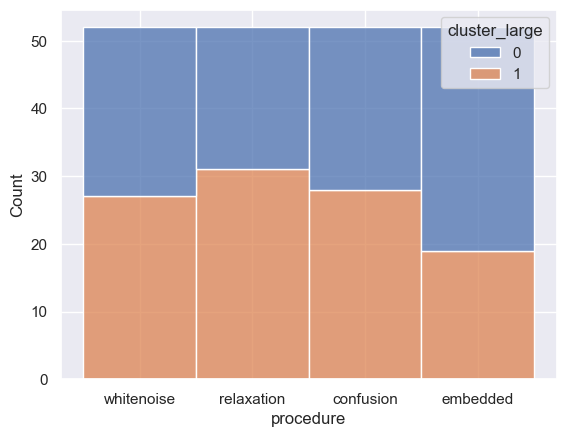

In [86]:
sns.histplot(data=session_data, x='procedure', hue=self_report['cluster_large'], multiple='stack', bins=10)

<Axes: xlabel='gpt_classification', ylabel='Count'>

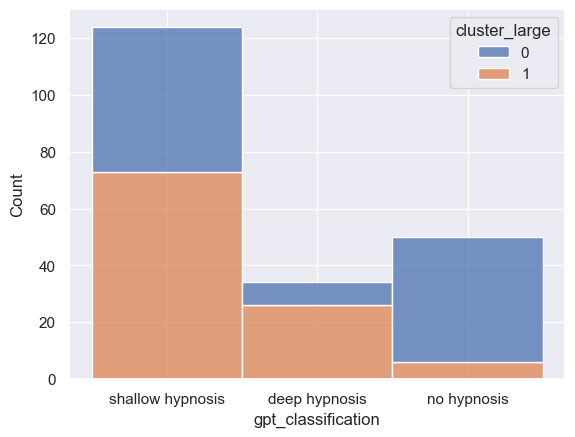

In [87]:
sns.histplot(data=session_data, x='gpt_classification', hue=self_report['cluster_large'], multiple='stack', bins=10)

#### Topic model

In [27]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import ast

# Preprocess the text data for each cluster
texts_cluster_0 = self_reports.query('cluster_KMeans == 0')['english_text']
texts_cluster_1 = self_reports.query('cluster_KMeans == 1')['english_text']

# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
X_0 = vectorizer.fit_transform(texts_cluster_0)
X_1 = vectorizer.fit_transform(texts_cluster_1)

# X_0 = self_reports.query('cluster_KMeans == 0')['ada_embedding'].values
# X_1 = self_reports.query('cluster_KMeans == 1')['ada_embedding'].values
# X_0 = np.array([ast.literal_eval(i) for i in X_0])
# X_1 = np.array([ast.literal_eval(i) for i in X_1])

# Fit LDA
lda_0 = LatentDirichletAllocation(n_components=2)
lda_0.fit(X_0)

lda_1 = LatentDirichletAllocation(n_components=2)
lda_1.fit(X_1)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display topics for both clusters
display_topics(lda_0, vectorizer.get_feature_names_out(), 10)  # Top 5 words for cluster 0
display_topics(lda_1, vectorizer.get_feature_names_out(), 10)  # Top 5 words for cluster 1

Topic 0:
ocean eliminating hurting agitated room returning reads fast eat forgot
Topic 1:
eliminating reads hurting ocean room easy caused couldn barely agitated
Topic 0:
feel didn eyes bit end felt little like noise mind
Topic 1:
felt didn time state feel relaxed bit relax previous hypnosis


#### Frequency Analysis

In [4]:
from collections import Counter

# Function to get word frequency
def get_word_frequencies(texts):
    words = ' '.join(texts).split()
    return Counter(words)

freq_0 = get_word_frequencies(texts_cluster_0)
freq_1 = get_word_frequencies(texts_cluster_1)

# Display most common words in each cluster
print("Most common words in cluster 0:", freq_0.most_common(10))
print("Most common words in cluster 1:", freq_1.most_common(10))

Most common words in cluster 0: [('I', 361), ('was', 215), ('a', 155), ('the', 134), ('and', 128), ('to', 111), ('my', 108), ('of', 87), ('in', 83), ('felt', 73)]
Most common words in cluster 1: [('I', 451), ('the', 295), ('was', 233), ('to', 208), ('a', 130), ('and', 120), ('my', 119), ('it', 96), ('that', 78), ('of', 75)]


#### Visualization with WordCloud

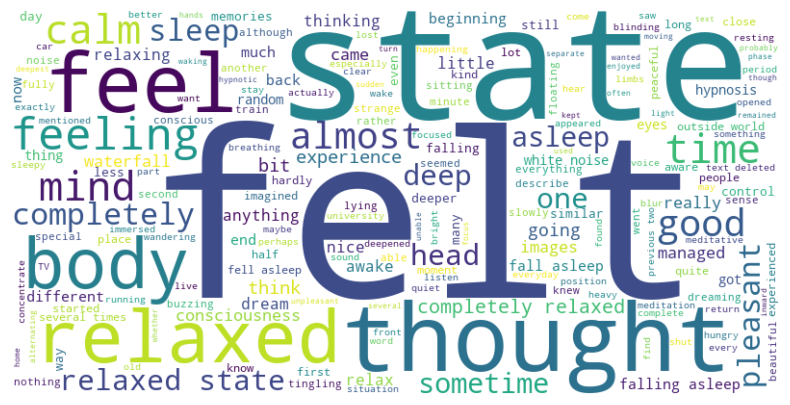

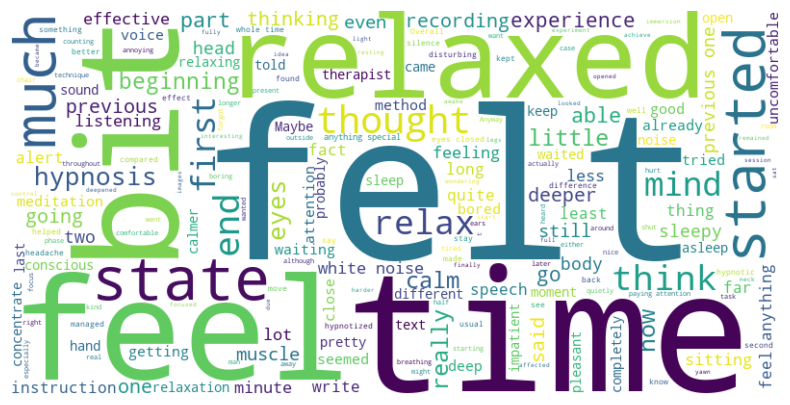

In [5]:
from wordcloud import WordCloud

def plot_wordcloud(texts):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_wordcloud(texts_cluster_0)
plot_wordcloud(texts_cluster_1)

#### Sentiment analysis

In [24]:
from transformers import pipeline

# Load the pre-trained sentiment analysis model
sentiment_model = pipeline("sentiment-analysis", model='distilbert-base-uncased-finetuned-sst-2-english',
                           device='mps')  # Use GPU for faster processing

# Example: apply it to texts in cluster 0 and cluster 1
# sentiments_cluster_0 = [sentiment_model(text) for text in texts_cluster_0]
sentiments_cluster_1 = [sentiment_model(text) for text in texts_cluster_1]

# Calculate the average sentiment score
def average_sentiment(sentiments):
    scores = [result[0]['score'] if result[0]['label'] == 'POSITIVE' else -result[0]['score'] for result in sentiments]
    return sum(scores) / len(scores)

# avg_sentiment_0 = average_sentiment(sentiments_cluster_0)
avg_sentiment_1 = average_sentiment(sentiments_cluster_1)

# print("Average sentiment in cluster 0:", avg_sentiment_0)
print("Average sentiment in cluster 1:", avg_sentiment_1)

/opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Average sentiment in cluster 1: -0.516060693646377


#### Emotional state detection

In [ ]:
# j-hartmann/emotion-english-distilroberta-base
# bhadresh-savani/distilbert-base-uncased-emotion
# mental/mental-bert-base-uncased
# nateraw/bert-base-uncased-emotion

In [ ]:
from huggingface_hub import login

# Use your personal API token here
login(token="my_token", add_to_git_credential=True)

In [ ]:
from transformers import pipeline

# Load pre-trained emotion detection model
emotion_classifier = pipeline("text-classification", model="nateraw/bert-base-uncased-emotion",
                              device='mps')

# Analyze emotions in the self-reports
emotions_cluster_0 = [emotion_classifier(text) for text in texts_cluster_0]
emotions_cluster_1 = [emotion_classifier(text) for text in texts_cluster_1]

In [98]:
def list_to_df(lst, column_prefix='', index=None):
    return pd.DataFrame([[i[0]['label'], i[0]['score']] for i in lst],
                        columns=[f'{column_prefix}_label', f'{column_prefix}_score']).set_axis(index, axis=0)

emotions_cluster_1_ = list_to_df(emotions_cluster_1, 'nateraw', texts_cluster_1.index)

In [99]:
emotions_cluster_0_ = list_to_df(emotions_cluster_0, 'nateraw', texts_cluster_0.index)

df = pd.concat([emotions_cluster_0_, emotions_cluster_1_], axis=0)
self_reports = pd.concat([self_reports, df], axis=1)

### Similarity between words associated with hypnosis depth and self reports embeddings
cosine similarity between the list of depth related words and the self reports in the current study.

#### Embed hypnosis depth related words

In [ ]:
# list of hypnosis depth related words
with open('data/OTKA/cardena2006.txt', 'r') as f:
    text = f.read()
print(text)

In [262]:
import openai
openai.api_key = "my_key"

# model='gpt-4o-2024-08-06'
prompt = f"Read and extract hypnosis depth related words, phrases and sentences from the following passage listed based on the level of hypnosis depth: '{text}'"
response = openai.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a investigator who reads and extracts hypnosis depth related words, phrases and sentences from a texts."},
        {"role": "user", "content": prompt}
    ],
    max_tokens=2000,
    temperature=0  # Deterministic output
)
# res = response.choices[0].message.content.strip()
# with open('data/OTKA/extracted_text.txt', 'w') as f:
#     f.write(res)

In [245]:
hypnosis_experiences = [
    # No Hypnosis
    '"Relaxation"',
    'No changes in ordinary sensations',
    'No changes in body image',
    'No changes in feelings',
    'No changes in time sense',
    'No changes in identity',
    'No changes in memory',
    'No changes in perception',
    'No changes in thought',
    'No changes in concentration',
    'No changes in state of consciousness',
    'No changes in control',
    'No changes in behavior',
    'No changes in interpersonal phenomena',
    'No changes in or transpersonal experiences.',

    # Light/Medium Hypnosis
    '"Feeling light"',
    '"Spinning"',
    'Changes in body image (e.g., "my hands have been growing")',
    'Loss of touch with the environment',
    'Experiences of floating and flying (and sometimes sinking)',
    'Increasing disconnection from the body and the environment',
    'Shift from conceptual thinking to spontaneous imagery',
    'Imagery becoming more elaborate and vivid',
    'Cross-modal or synesthetic imagery',

    # Deep Hypnosis
    'Sense of the body floating and being disembodied',
    '"Floating"',
    "flying",
    "mind leaving the body",
    "No sense of time,",
    'time becoming "still" or "slowing down"',
    'Positive emotions: "love," "wonder," "freedom"',
    'Dysphoric emotion: "fear"',
    '"Difficulties remembering" everyday activities',
    '"Suddenly remembering" forgotten events',
    '"Greater control" over mental states',
    '"Free-floating" attention',
    '"Change of modality" from concepts to images',
    '"Having no thoughts"',
    'Imagery: "increased quality," "sustained sequences," "spontaneous imagery," "greater realness," "imagery not referable to a sensory modality"',
    '"Dreaming" as a descriptor',
    '"Flashes of light," "brightness," "great obscurity"',
    'Transpersonal experiences: "being one with everything," "greater relatedness," "loss of identity," "in touch with one’s inner self"',
    '"Being in a different reality"',
    '"Profound personal insight"',
    '"Increased sense of potentiality"',
    '"Increased meaningfulness"',
    'Disconnection with the body and the environment',
    'Sense of connectedness with everything',

    # Very Deep Hypnosis
    '"Merging with pure light or energy and finding one’s innermost core"',
    '"I am not matter anymore... I am just energy"',
    'Euphoria',
    'Sense of potentiality, meaningfulness, insight, and connectedness',
    '"In another plane of reality"',
    'Specific common features: bodies of water, tunnels, viscous substances'
]
hypnosis_experiences = [i.strip('"') for i in hypnosis_experiences]

In [ ]:
# model='gpt-4o-2024-08-06'
prompt = f"here is a list of words/phrases/clauses and even some sentences commonly associated with various level of hypnosis depth. convert them into a full self report sentence.{hypnosis_experiences}"
response = openai.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "I'll give you some hints(word/phrases/clauses) and convert them into full self report sentences (for example if I gave you this clause 'no changes in ordinary sensation' create a self report such as 'I didn't experienced any changes in my ordinary sensations'."},
        {"role": "user", "content": prompt}
    ],
    max_tokens=2100,
    temperature=0  # Deterministic output
)

In [271]:
full_hypnotic_experinece = response.choices[0].message.content.strip().split('\n')
full_hypnotic_experinece = [i.split(' ', 1)[1] for i in full_hypnotic_experinece]

In [274]:
# remove numbers from the beginning of the sentences
exp_dict = {'full_report': full_hypnotic_experinece, 'associated_phrases': hypnosis_experiences}
exp_df = pd.DataFrame(exp_dict)
exp_df.to_csv('data/OTKA/hypnotic_experiences.csv', index=False)

In [275]:
from openai import OpenAI
client = OpenAI(api_key="my_key")

hypn_exps_full = []
for i in full_hypnotic_experinece:
    hypn_exps_full.append(client.embeddings.create(input=i, model='text-embedding-3-large').data[0].embedding)

hypn_exps_full = np.array(hypn_exps_full)

# # save hypn_exps embeddings as an numpy array
# np.save('data/OTKA/nlp/cardena2006/cardena_phrase_embedding3-large.npy', hypn_exps_full)

In [278]:
def get_embedding(text, model="text-embedding-3-large"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

self_report['ada_embedding_large'] = self_report.english_text.apply(lambda x: get_embedding(x, model='text-embedding-3-large'))

#### Cosine Similarities

In [1]:
import pandas as pd
import numpy as np
import ast
self_report = pd.read_csv('data/OTKA/embedded_text_emb_3_large.csv')
hypn_exps_full = np.load('data/OTKA/nlp/cardena2006/cardena_phrase_embedding3-large.npy')

In [2]:
self_report_embeddings = self_report['ada_embedding_large'].values
self_report_embeddings = [ast.literal_eval(i) for i in self_report_embeddings]

from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity between each self-report embedding and hypnosis phrases embeddings
similarities = cosine_similarity(self_report_embeddings, hypn_exps_full)

#### visualisations

In [ ]:
# devide different hypnosis depth levels
hypnosis_experiences = pd.read_csv('data/OTKA/nlp/cardena2006/hypnotic_experiences.csv')
# border_experiences = ['No changes in or transpersonal experiences.', 'Cross-modal or synesthetic imagery', 'Sense of connectedness with everything']
# border_idx = [hypnosis_experiences.index(i)+1 for i in border_experiences]
border_idx = [(0, 15), (15, 24), (24, 48), (48, 55)]
hypnosis_experiences.iloc[0:15, 1]

##### barplot

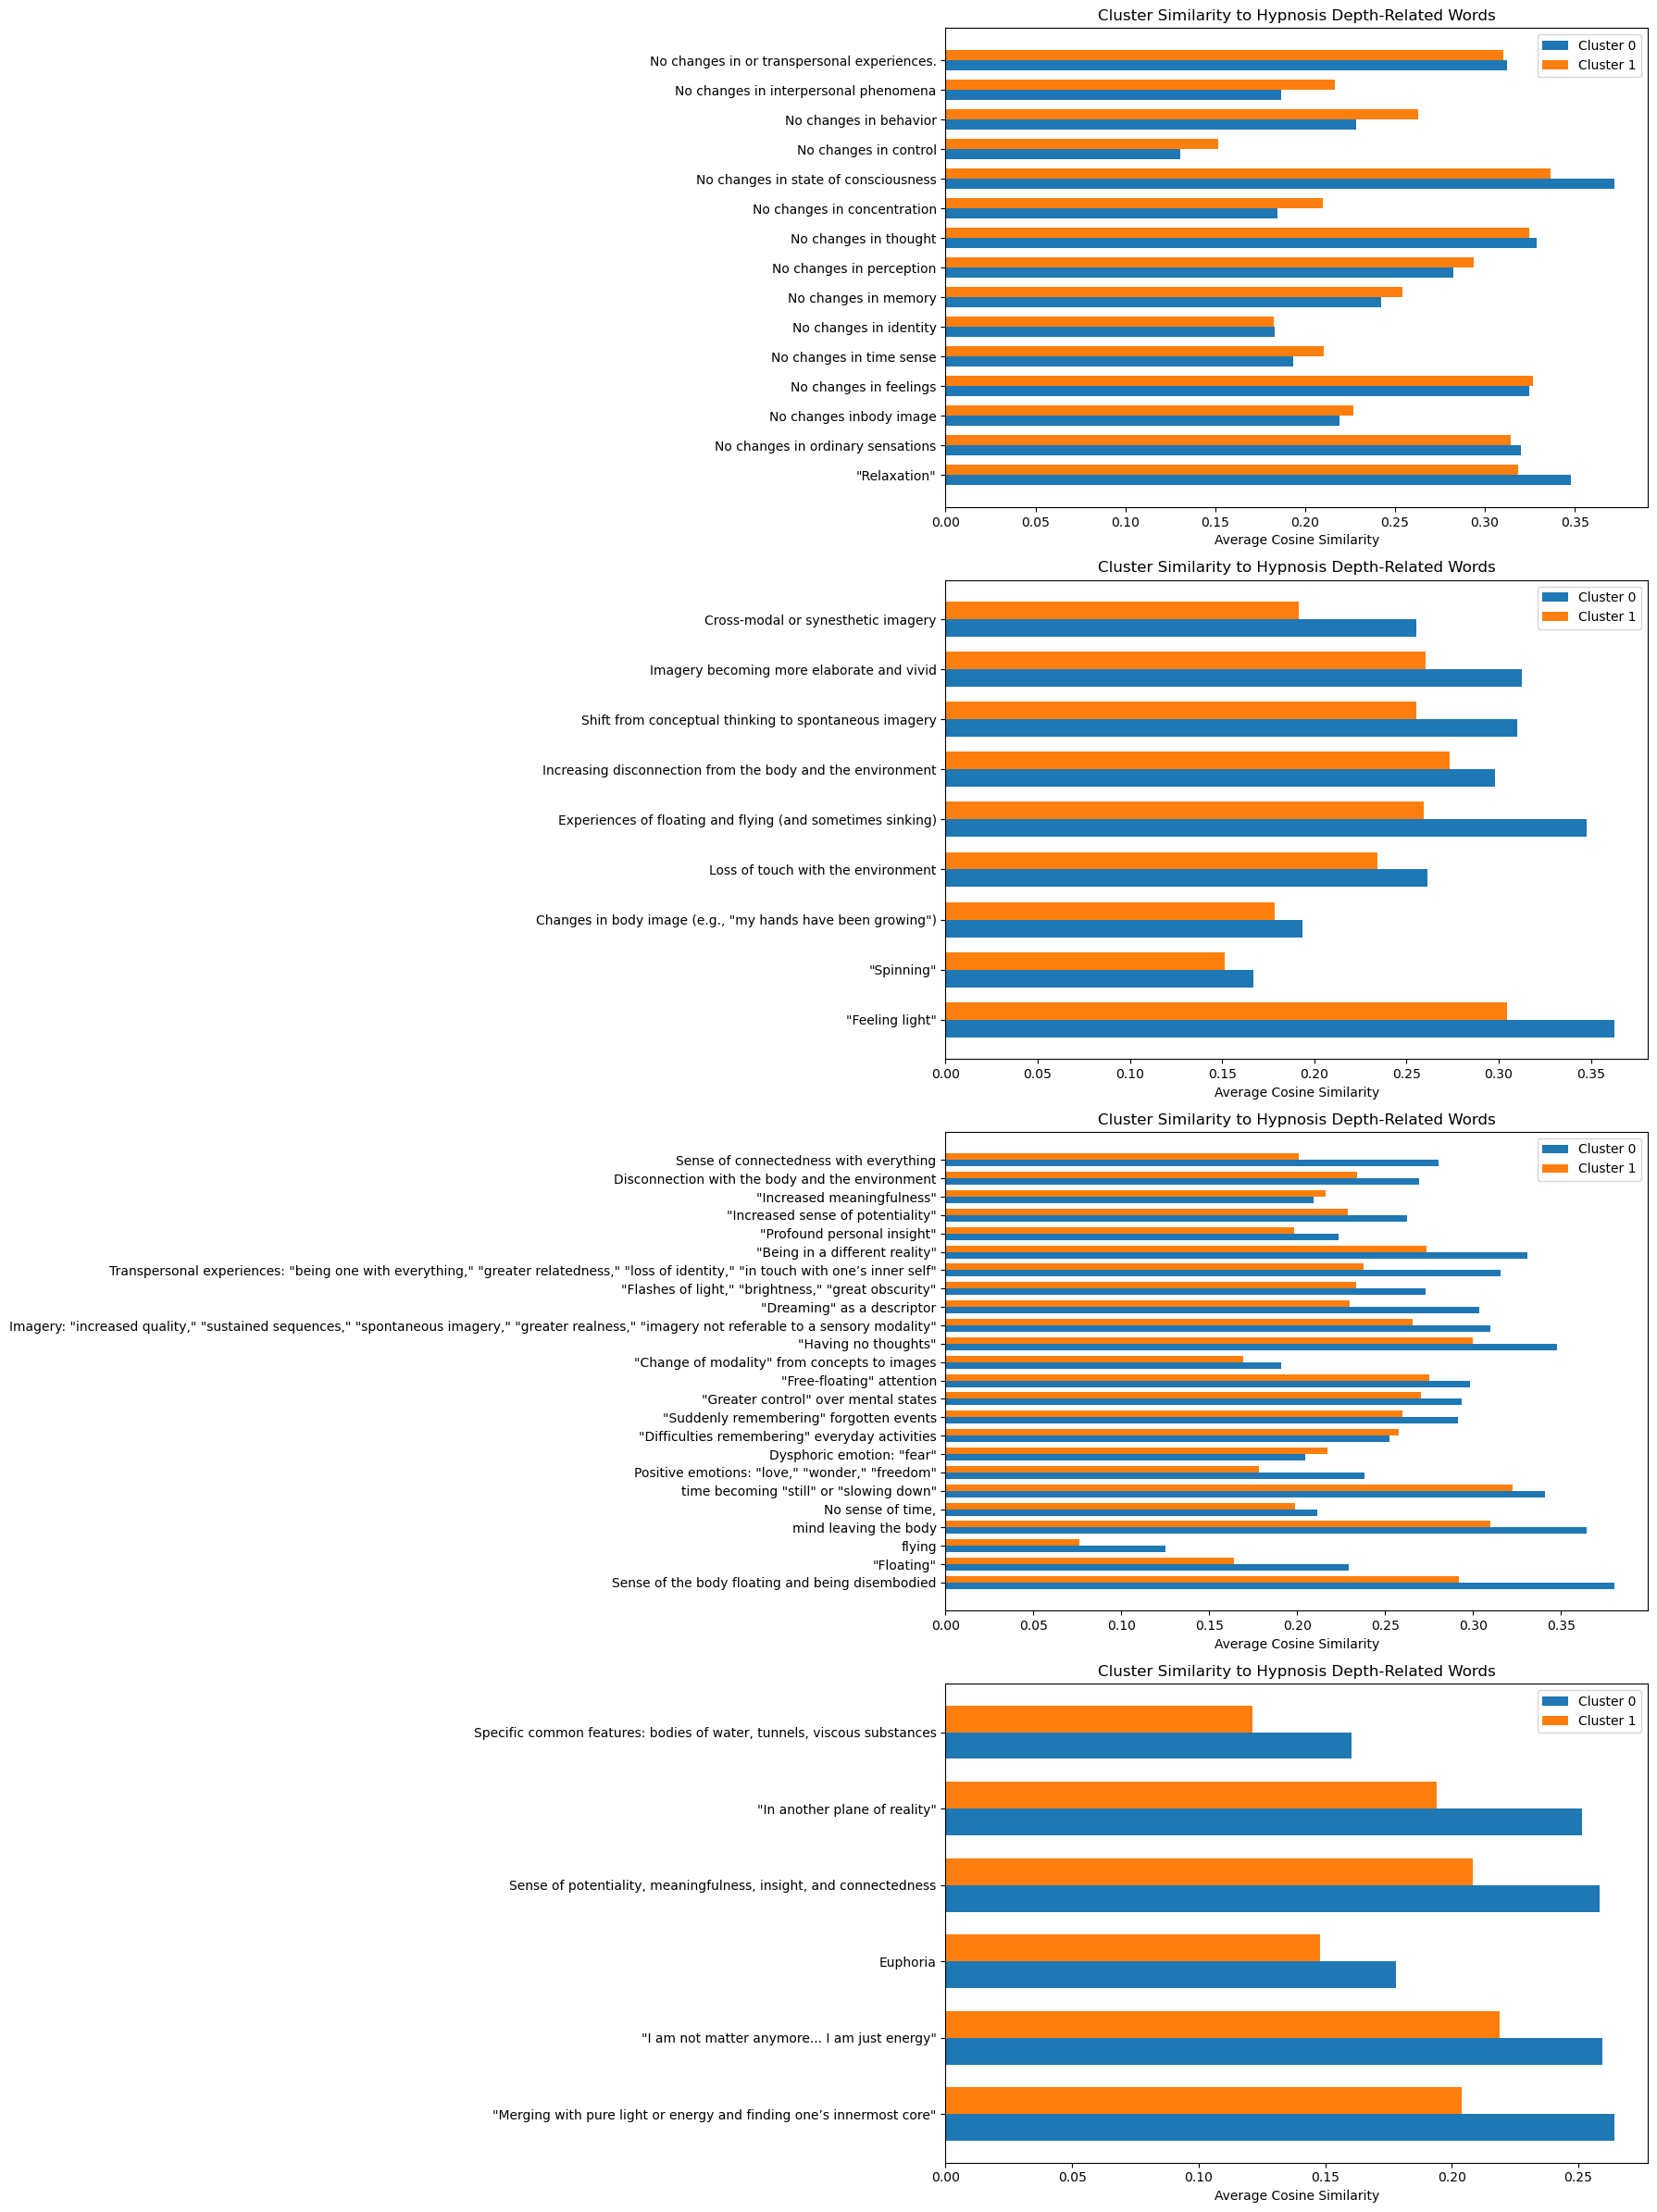

In [166]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(4, 1, figsize=(6*3, 8*3))

for i, idx in enumerate(border_idx):
    words = hypnosis_experiences[idx[0]:idx[1]]
    cluster_0_similarities = similarities[idx_0][:, idx[0]:idx[1]].mean(axis=0)
    cluster_1_similarities = similarities[idx_1][:, idx[0]:idx[1]].mean(axis=0)

    # Plot
    bar_width = 0.35
    index = np.arange(len(words))

    ax[i].barh(index, cluster_0_similarities, bar_width, label='Cluster 0')
    ax[i].barh(index + bar_width, cluster_1_similarities, bar_width, label='Cluster 1')
    # ax[i].set_ylabel('Hypnosis Depth-Related Words')
    ax[i].set_xlabel('Average Cosine Similarity')
    ax[i].set_title('Cluster Similarity to Hypnosis Depth-Related Words')
    ax[i].set_yticks(index + bar_width / 2)
    ax[i].set_yticklabels(words, rotation=0)
    ax[i].legend()

plt.tight_layout()
    # plt.show()


##### Scatterplot

In [313]:
idx_0 = self_report.query('cluster_large == 0').index
idx_1 = self_report.query('cluster_large == 1').index

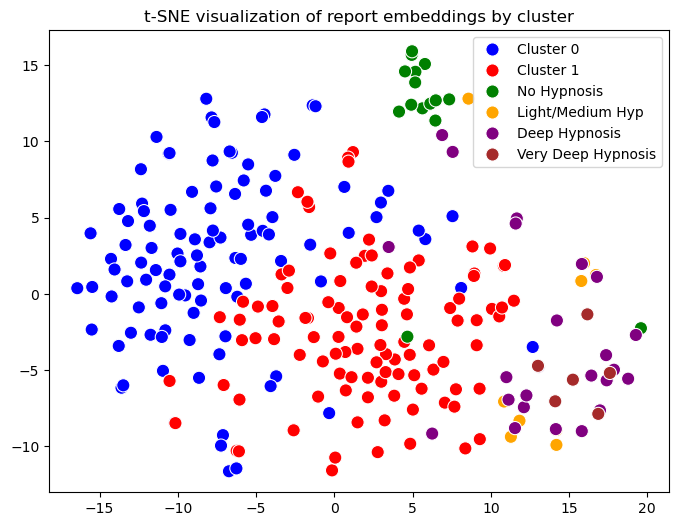

In [315]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

cluster_0_embeddings = self_report_embeddings[idx_0]
cluster_1_embeddings = self_report_embeddings[idx_1]

# Fit t-SNE on report embeddings (concatenate both cluster 0 and cluster 1 embeddings)
embeddings = np.vstack([cluster_0_embeddings, cluster_1_embeddings])  # Your self-report embeddings
labels = ['Cluster 0'] * len(cluster_0_embeddings) + ['Cluster 1'] * len(cluster_1_embeddings)

labels_words = ['No Hypnosis'] * 15 + ['Light/Medium Hyp'] * 9 + ['Deep Hypnosis'] * 24 + ['Very Deep Hypnosis'] * 6

embeddings_words = np.vstack([embeddings, hypn_exps_full])
labels_embeddings_words = labels + labels_words

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(embeddings_words)
# tsne_results_words = tsne.fit_transform(hypn_exps_full)

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=labels_embeddings_words, palette=['blue', 'red', 'green', 'orange', 'purple', 'brown'], s=90)
# sns.scatterplot(x=tsne_results_words[:,0], y=tsne_results_words[:,1], hue=labels_words, palette=['green', 'orange', 'purple', 'brown'])
plt.title('t-SNE visualization of report embeddings by cluster')
plt.show()

##### heatmap

In [ ]:
hypnosis_experiences = pd.read_csv('data/OTKA/nlp/cardena2006/hypnotic_experiences.csv')
border_idx = [(0, 15), (15, 24), (24, 48), (48, 55)]
hypnosis_experiences.iloc[0:15, 1]

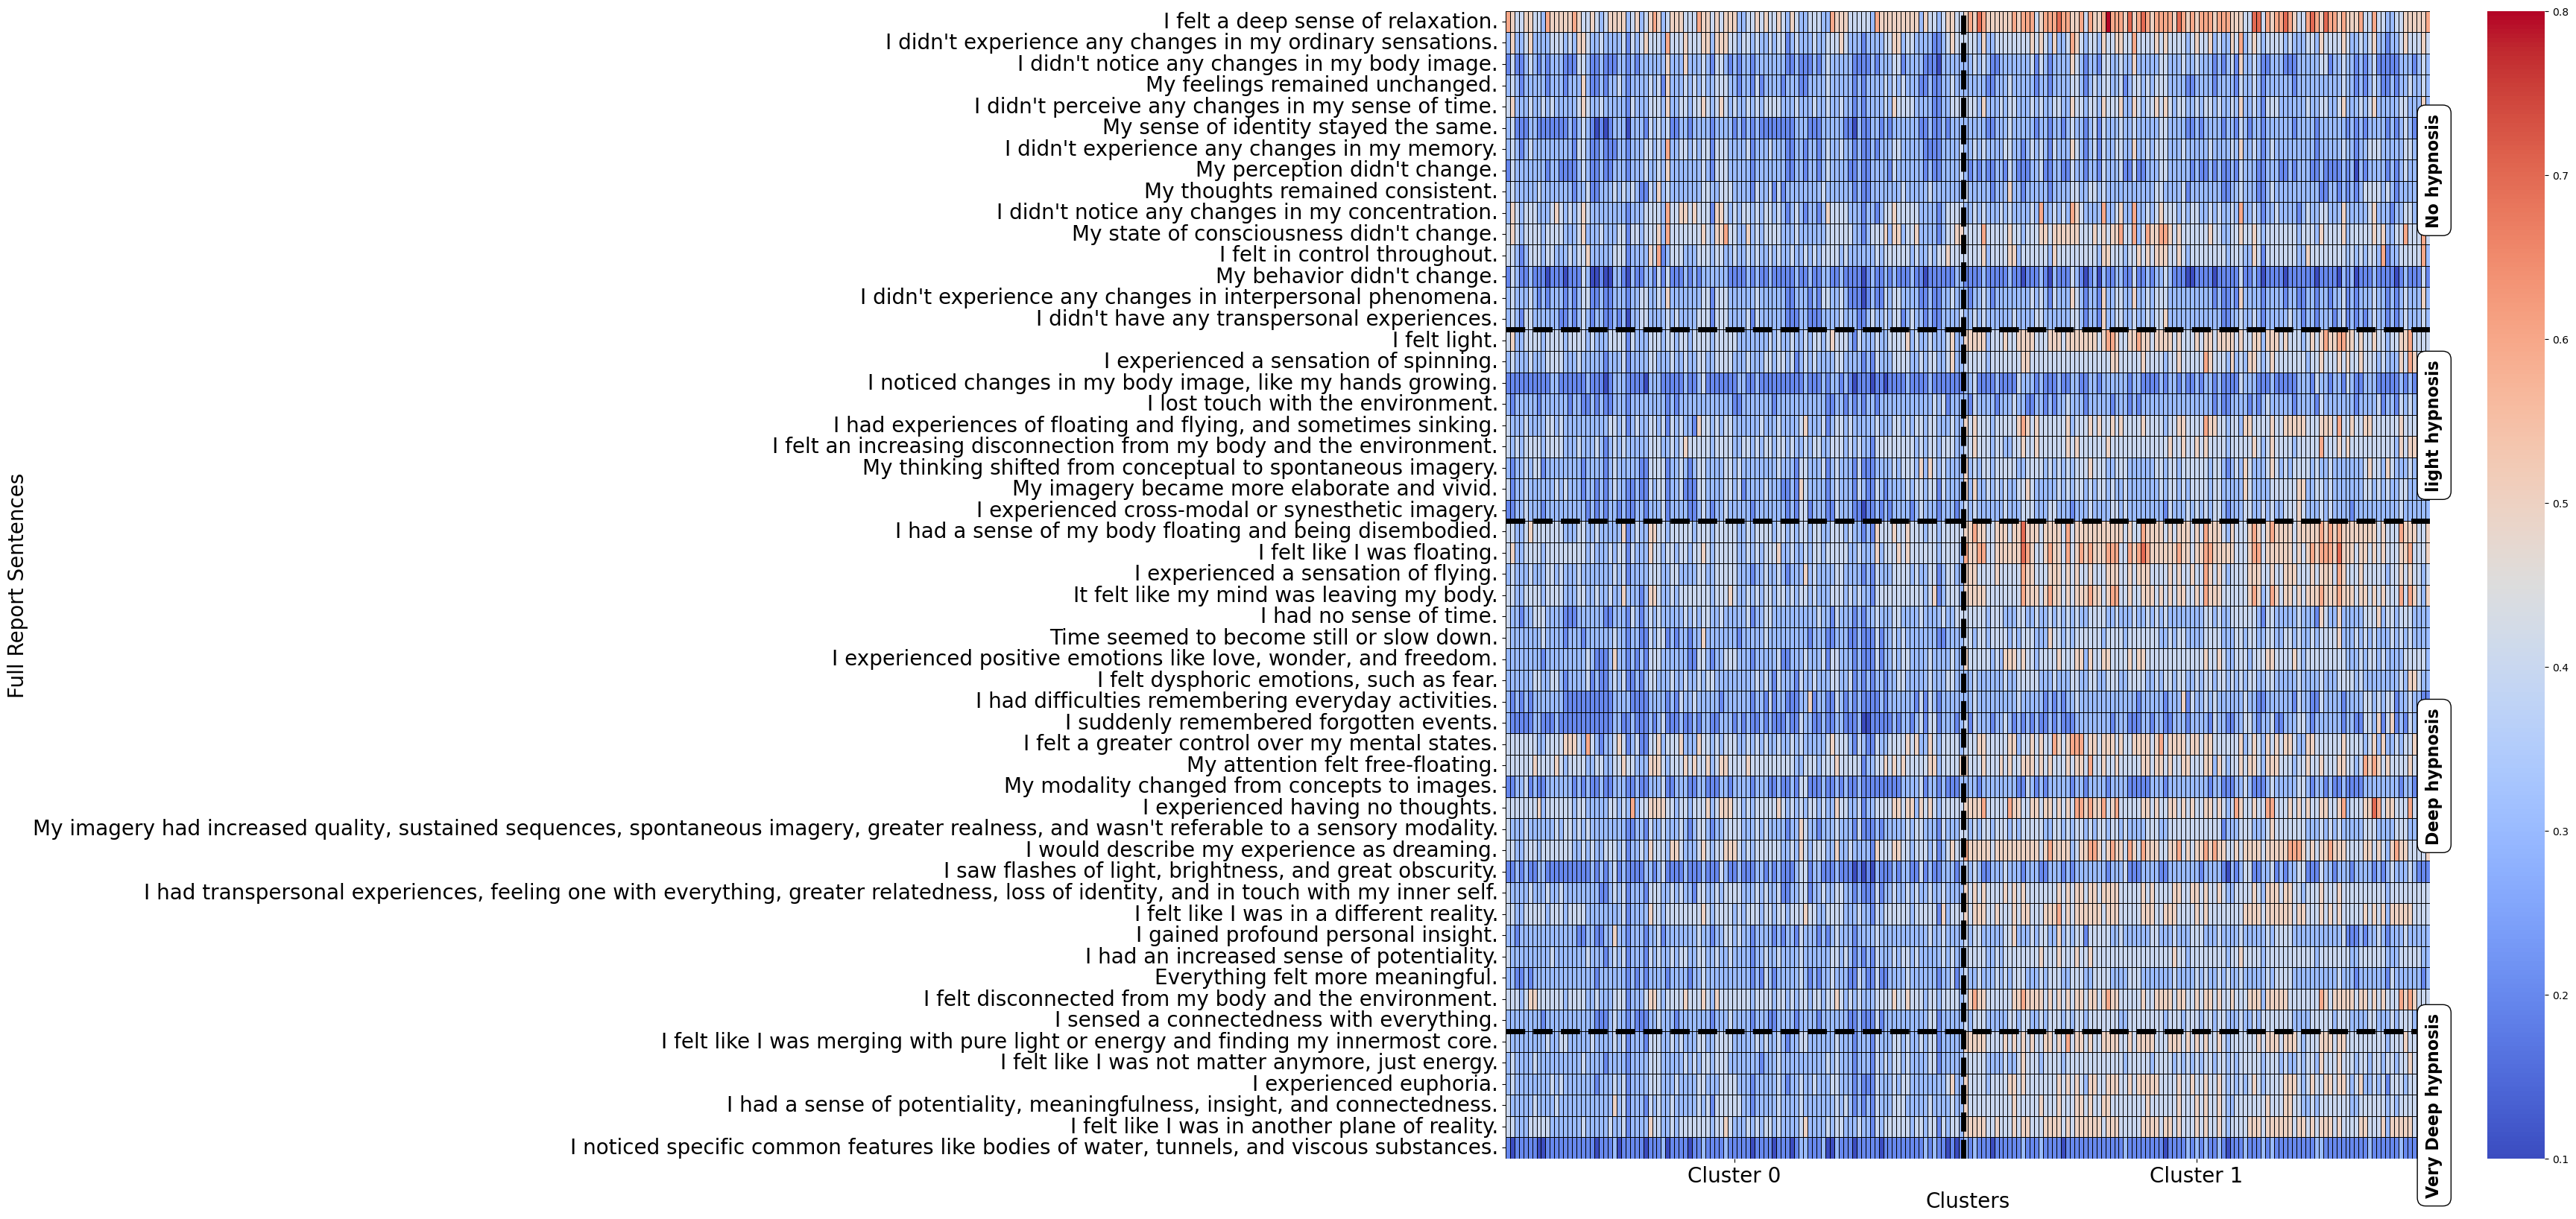

In [58]:
idx_0 = self_report.query('cluster_large == 0').index
idx_1 = self_report.query('cluster_large == 1').index
similarities_ordered_l = np.vstack([similarities[idx_0], similarities[idx_1]])

border_idx = {'No hypnosis':(0, 15),
              'light hypnosis':(15, 24),
              'Deep hypnosis':(24, 48),
              'Very Deep hypnosis':(48, 55)}


import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the y-axis labels
full_report = hypnosis_experiences['full_report']
y_labels = full_report.tolist()

# Create the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(similarities_ordered_l.T.round(1), cmap='coolwarm', cbar=True, xticklabels=False, yticklabels=y_labels, fmt=".2f", linewidths=.5, linecolor='black')

# Add vertical lines to separate the clusters
plt.axvline(len(idx_0), color='black', linestyle='--', linewidth=5)

# Add x-axis labels
plt.xticks([len(idx_0) / 2, len(idx_0) + len(idx_1) / 2], ['Cluster 0', 'Cluster 1'], rotation=0, fontsize=20)
plt.yticks(fontsize=20)

# Add horizontal lines to separate the categories
for label, (start, end) in border_idx.items():
    plt.axhline(end, color='black', linestyle='--', linewidth=5)
    plt.text(len(similarities_ordered_l) + 1, (start + end) / 2, label, ha='center', va='center', fontsize=16, fontdict={'weight': 'bold'}, rotation=90, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# plt.title('Heatmap of Similarities', fontsize=24, weight='bold')
plt.xlabel('Clusters', fontsize=20)
plt.ylabel('Full Report Sentences', fontsize=20)
plt.show()


<Axes: >

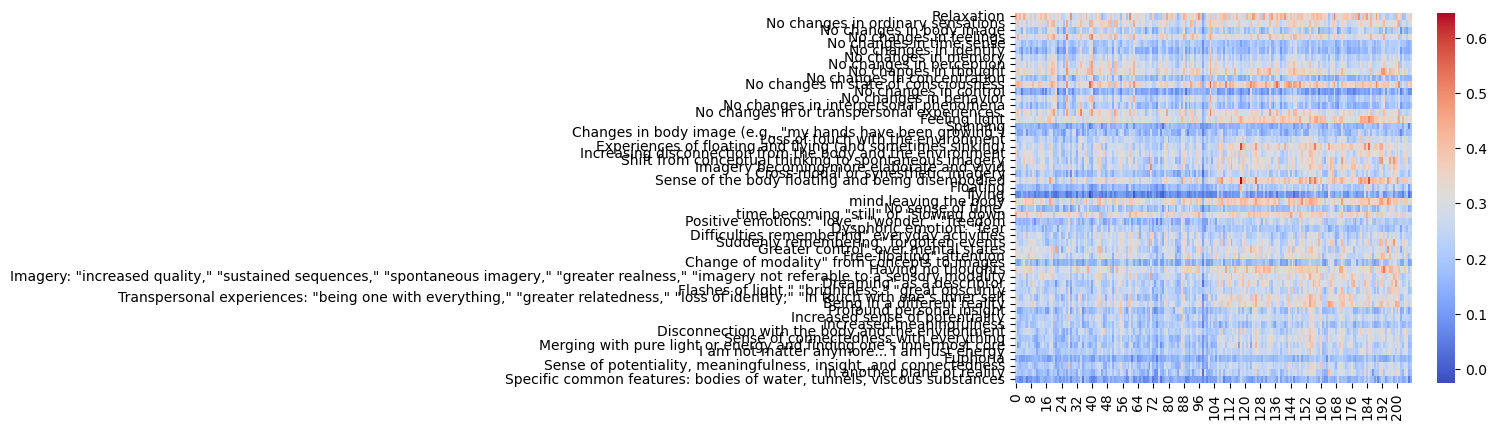

In [261]:
sns.heatmap(similarities_ordered.T, cmap='coolwarm', fmt=".2f", yticklabels=hypnosis_experiences)

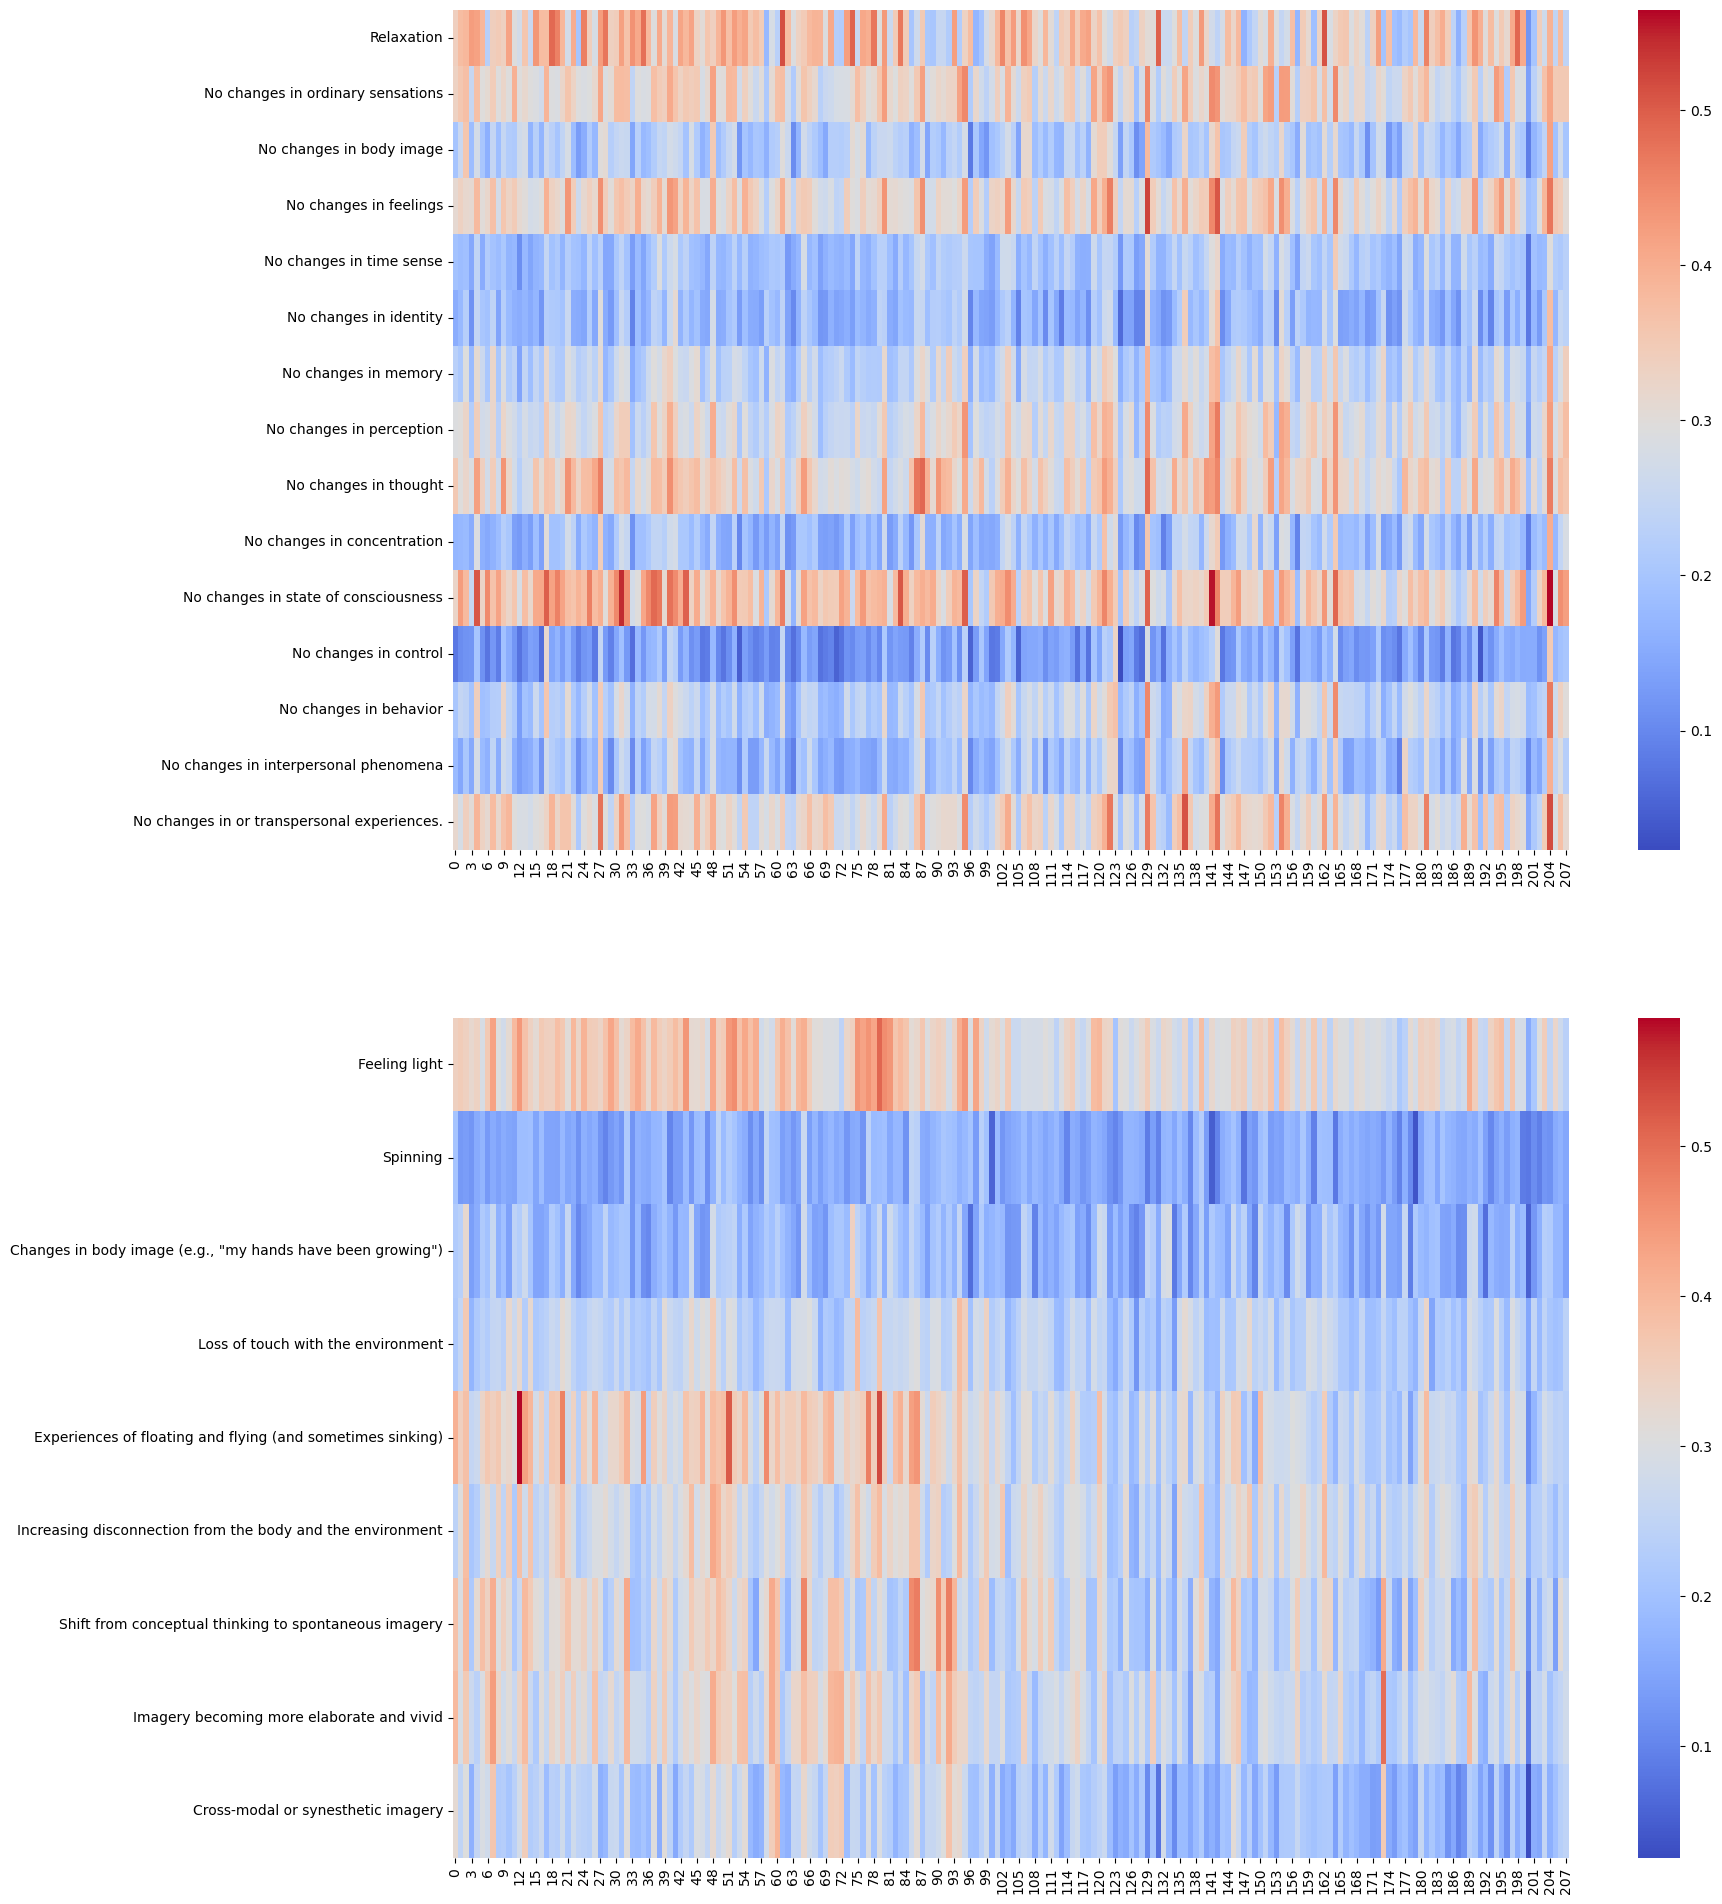

In [252]:
# Create heatmap

fig, axes = plt.subplots(2, 1, figsize=(6*3, 8*3))


for i, idx in enumerate(border_idx[:2]):
    words = hypnosis_experiences[idx[0]:idx[1]]
    sns.heatmap(similarities_ordered[:, idx[0]:idx[1]].T, yticklabels=words,
                cmap='coolwarm', ax=axes[i])
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['Cluster 0', 'Cluster 1'])


### Other clustering methods

In [3]:
# upload the cluster embeddings
import ast
self_report = pd.read_csv('data/OTKA/embedded_text_emb_3_large.csv')
self_report_embeddings = self_report['ada_embedding_large'].values
self_report_embeddings = np.array([ast.literal_eval(i) for i in self_report_embeddings])

#### GMM

In [14]:
from sklearn.mixture import GaussianMixture

def cluster_embeddings(embeddings, n_clusters=2):
    gmm = GaussianMixture(n_components=n_clusters, random_state=0).fit(embeddings)
    return gmm.predict(embeddings)

cluster_labels = cluster_embeddings(self_report_embeddings, n_clusters=2)

In [16]:
np.unique(cluster_labels, return_counts=True)[1]/len(cluster_labels)

array([0.49519231, 0.50480769])

In [21]:
# compare the clusters
kmeans_clusters = self_report['cluster_large'].values
gmm_clusters = cluster_labels

all(kmeans_clusters == gmm_clusters)

True

#### Agglomerative Hierarchical Clustering

In [52]:
from sklearn.cluster import AgglomerativeClustering

def cluster_embeddings(embeddings, n_clusters=2):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(embeddings)
    return agg_clustering.labels_

cluster_labels = cluster_embeddings(self_report_embeddings, n_clusters=2)

In [53]:
np.unique(cluster_labels, return_counts=True)[1]/len(cluster_labels)

array([0.60576923, 0.39423077])

In [ ]:
idx_2 = np.where(cluster_labels != kmeans_clusters)
cluster_labels[idx_2] = 2

<Axes: >

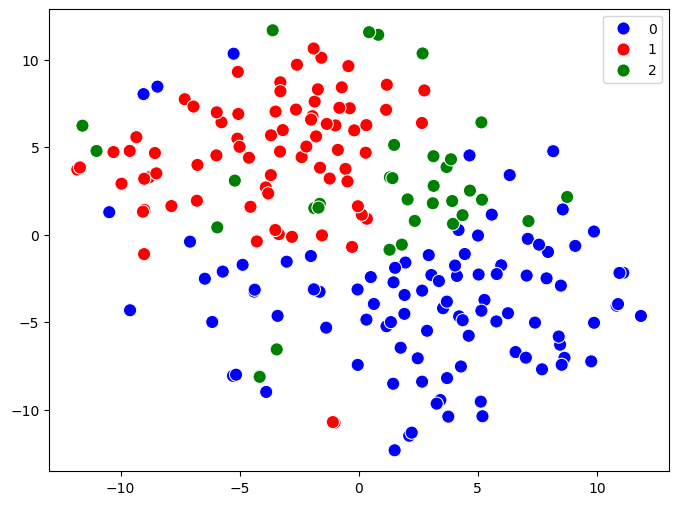

In [45]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Fit t-SNE on report embeddings
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(self_report_embeddings)

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=cluster_labels, palette=['blue', 'red', 'green'], s=90)


In [89]:
hypn_exps_full = np.load('data/OTKA/nlp/cardena2006/cardena_phrase_embedding3-large.npy')

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns


# Fit t-SNE on report embeddings (concatenate both cluster 0 and cluster 1 embeddings)
labels_words = ['No Hypnosis'] * 15 + ['Light/Medium Hyp'] * 9 + ['Deep Hypnosis'] * 24 + ['Very Deep Hypnosis'] * 6

embeddings_words = np.vstack([self_report_embeddings, hypn_exps_full])
labels_embeddings_words = self_report['cluster_large'].to_list() + labels_words

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(embeddings_words)
# # tsne_results_words = tsne.fit_transform(hypn_exps_full)

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:,1], hue=labels_embeddings_words, palette=['blue', 'red', 'green', 'orange', 'purple', 'brown'],
                marker=['x', 'x', 'o', 'o', 'o'], s=90)
plt.title('t-SNE visualization of report embeddings by cluster')

#### 3D Visualisation

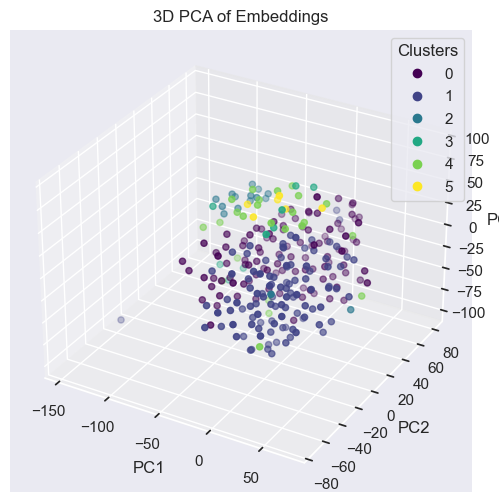

In [108]:
# 3d visualisation of 3d embeddings
# Required Libraries
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Assuming `embeddings` is your high-dimensional data (e.g., from text embeddings)
# Reduce dimensions to 3 components
pca = TSNE(n_components=3)
embeddings = np.vstack([self_report_embeddings, hypn_exps_full])
labels_words = [2] * 15 + [3] * 9 + [4] * 24 + [5] * 6
labels = self_report['cluster_large'].to_list() + labels_words
components = pca.fit_transform(embeddings)

# Visualize in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting the points
scatter = ax.scatter(components[:, 0], components[:, 1], components[:, 2], c=labels, cmap='viridis')

# Adding labels and titles
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA of Embeddings')

plt.legend(*scatter.legend_elements(), title='Clusters')

# Show the plot
plt.show()